# NO2 Models

## Init: Prepare Packages and Configuration

In [1]:
# Cancel the comment to install all the packages and libraries needed.
# ! pip install rasterio matplotlib rasterstats ipynbname imageio tqdm rasterstats
# ! pip install numpy==1.24.4CURR_PATH
# ! pip install libpysal
# ! pip install geopandas libpysal esda matplotlib
# ! pip install seaborn

# Configuration
from pathlib import Path
import sys

CURR_PATH = Path().resolve()            # current file path
REPO_PATH = CURR_PATH.parent            # current repository path
DATA_PATH = REPO_PATH / "data"          # path for saving the data
DEMO_PATH = DATA_PATH / "demo-data"     # path for demo purpose 

SRC_PATH = REPO_PATH / "src"    # path for other sources
sys.path.append(str(SRC_PATH))  # add src to system path to import custom functions

# print(REPO_PATH)

In [2]:
import geopandas as gpd
import pandas as pd
from tqdm import tqdm
from datetime import timedelta, datetime
import os

# 假设文件按日期排序，文件名可解析为日期
mesh_folder = DATA_PATH / 'addis-mesh-data'
file_paths = sorted(mesh_folder.glob("*.gpkg"))  # 你的 730 个 GPKG 文件路径

all_data = []

for i, path in tqdm(enumerate(file_paths), total=len(file_paths)):
    date = datetime(2023, 1, 1) + timedelta(days=i)  # 修改起始日期为真实值
    gdf = gpd.read_file(path)
    gdf["date"] = date
    all_data.append(gdf)

full_df = pd.concat(all_data, ignore_index=True)


100%|██████████| 731/731 [00:14<00:00, 50.84it/s]
C:\Users\87383\AppData\Local\Temp\ipykernel_42208\1835601351.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat(all_data, ignore_index=True)


In [ ]:
## Yesterday NO2
full_df.sort_values(["geom_id", "date"], inplace=True)
full_df["no2_lag1"] = full_df.groupby("geom_id")["no2_mean"].shift(1)


In [4]:
import warnings
from libpysal.weights import KNN

# 假设 sample_gdf 是某一天的网格
sample_gdf = full_df[full_df['date'] == full_df['date'].min()].reset_index(drop=True)

# 设置 K（邻居个数）
k_neighbors = 8  # 通常选择8邻域

# 构建 KNN 空间权重
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    w = KNN.from_dataframe(sample_gdf, k=k_neighbors)

# row-standardized weights（可选）
w.transform = 'r'

# 构建 geom_id -> 邻居 geom_id 的映射字典
geom_id_to_neighbors = {}

# sample_gdf 的索引 i <=> geom_id 的映射
index_to_geom_id = dict(sample_gdf['geom_id'].items())

for i, neighbors in w.neighbors.items():
    geom_id = index_to_geom_id[i]
    neighbor_ids = [index_to_geom_id[j] for j in neighbors]
    geom_id_to_neighbors[geom_id] = neighbor_ids


In [5]:
geom_id_to_neighbors

{0: [5, 1, 6, 14, 2, 15, 13, 7],
 1: [6, 0, 2, 5, 7, 15, 3, 14],
 2: [3, 7, 1, 8, 6, 4, 16, 0],
 3: [2, 8, 4, 7, 9, 17, 1, 16],
 4: [9, 3, 8, 2, 18, 7, 17, 16],
 5: [0, 6, 14, 1, 15, 13, 23, 7],
 6: [1, 15, 5, 7, 0, 14, 2, 16],
 7: [8, 2, 16, 6, 3, 17, 1, 15],
 8: [7, 3, 9, 17, 2, 16, 4, 18],
 9: [4, 18, 8, 3, 17, 7, 27, 2],
 10: [19, 11, 20, 28, 12, 29, 21, 30],
 11: [20, 10, 12, 19, 21, 13, 29, 22],
 12: [13, 21, 11, 22, 20, 14, 30, 10],
 13: [12, 22, 14, 21, 23, 5, 11, 31],
 14: [23, 13, 5, 15, 22, 24, 6, 12],
 15: [24, 14, 6, 16, 23, 5, 25, 7],
 16: [17, 25, 7, 15, 26, 8, 24, 6],
 17: [16, 26, 18, 8, 25, 7, 27, 9],
 18: [27, 9, 17, 26, 8, 16, 36, 4],
 19: [10, 28, 20, 29, 11, 38, 21, 39],
 20: [11, 29, 19, 21, 28, 10, 30, 12],
 21: [22, 30, 12, 20, 13, 31, 29, 11],
 22: [21, 13, 31, 23, 30, 12, 32, 14],
 23: [32, 14, 24, 22, 13, 33, 31, 15],
 24: [15, 33, 23, 25, 32, 14, 16, 34],
 25: [26, 16, 34, 24, 17, 35, 33, 15],
 26: [25, 35, 17, 27, 34, 16, 36, 18],
 27: [18, 36, 26, 35, 17,

In [28]:
# full_df

In [6]:
def compute_neighbor_no2(row, df_dict):
    date = row["date"]
    geom_id = row["geom_id"]
    prev_date = date - timedelta(days=1)
    if prev_date not in df_dict:
        return None
    prev_day_df = df_dict[prev_date]
    neighbors = geom_id_to_neighbors.get(geom_id, [])
    values = prev_day_df[prev_day_df["geom_id"].isin(neighbors)]["no2_mean"]
    return values.mean() if not values.empty else None

# 按天切分数据用于快速访问
df_by_date = {d: gdf for d, gdf in full_df.groupby("date")}
full_df["no2_neighbor_yesterday"] = full_df.apply(lambda row: compute_neighbor_no2(row, df_by_date), axis=1)


[0]	train-rmse:0.00002	eval-rmse:0.00002


d:\Software\Anaconda3\envs\gdp_env\Lib\site-packages\xgboost\core.py:723: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[1]	train-rmse:0.00002	eval-rmse:0.00002
[2]	train-rmse:0.00002	eval-rmse:0.00002
[3]	train-rmse:0.00002	eval-rmse:0.00002
[4]	train-rmse:0.00002	eval-rmse:0.00002
[5]	train-rmse:0.00002	eval-rmse:0.00002
[6]	train-rmse:0.00002	eval-rmse:0.00002
[7]	train-rmse:0.00002	eval-rmse:0.00002
[8]	train-rmse:0.00002	eval-rmse:0.00002
[9]	train-rmse:0.00002	eval-rmse:0.00002
[10]	train-rmse:0.00002	eval-rmse:0.00002
[11]	train-rmse:0.00002	eval-rmse:0.00002
[12]	train-rmse:0.00002	eval-rmse:0.00002
[13]	train-rmse:0.00002	eval-rmse:0.00002
[14]	train-rmse:0.00002	eval-rmse:0.00002
[15]	train-rmse:0.00002	eval-rmse:0.00002
[16]	train-rmse:0.00002	eval-rmse:0.00002
[17]	train-rmse:0.00002	eval-rmse:0.00002
[18]	train-rmse:0.00002	eval-rmse:0.00002
[19]	train-rmse:0.00002	eval-rmse:0.00002
[20]	train-rmse:0.00002	eval-rmse:0.00002
[21]	train-rmse:0.00002	eval-rmse:0.00002
[22]	train-rmse:0.00002	eval-rmse:0.00002
[23]	train-rmse:0.00002	eval-rmse:0.00002
[24]	train-rmse:0.00002	eval-rmse:0.00002
[

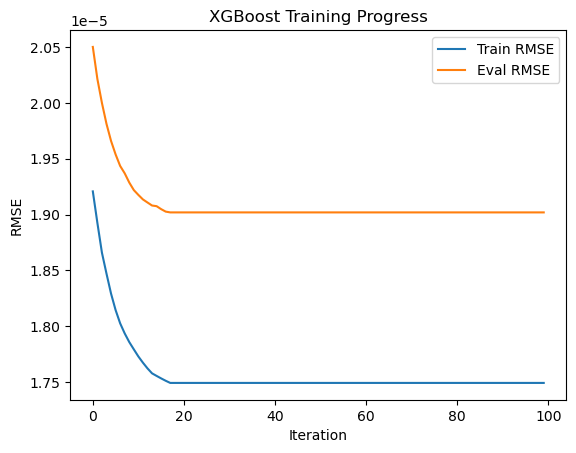

Feature Importances:
no2_neighbor_yesterday: 27.0
NTL_mean: 10.0
pop_sum_m: 6.0
no2_yesterday: 3.0
road_len: 0
road_share: 0
poi_count: 0
poi_share: 0
lu_industrial_area: 0
lu_industrial_share: 0
lu_commercial_area: 0
lu_commercial_share: 0
lu_residential_area: 0
lu_residential_share: 0
lu_retail_area: 0
lu_retail_share: 0
lu_farmland_area: 0
lu_farmland_share: 0
lu_farmyard_area: 0
lu_farmyard_share: 0
road_motorway_len: 0
road_trunk_len: 0
road_primary_len: 0
road_secondary_len: 0
road_tertiary_len: 0
road_residential_len: 0
fossil_pp_count: 0


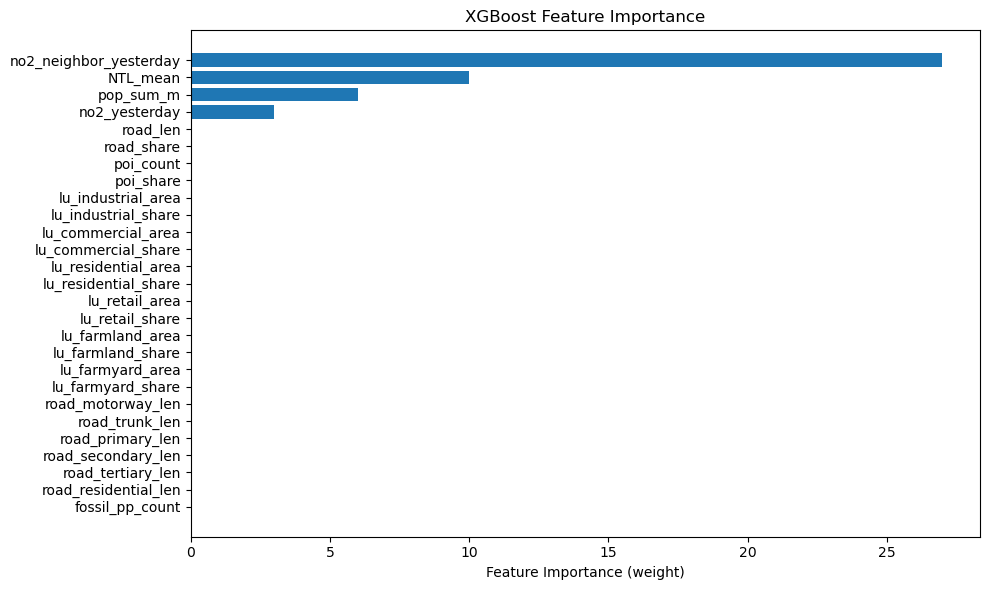

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# 数据清理，去除关键列缺失值
clean_df = full_df.dropna(subset=["no2_mean", "no2_lag1", "no2_neighbor_yesterday"])

# 特征列：辅助变量 + 其他所有除目标和非数值列
features = ["no2_lag1", "no2_neighbor_yesterday"] + [
    col for col in full_df.columns
    if col not in ["no2_mean", "geometry", "date", "geom_id", "no2_lag1", "no2_neighbor_yesterday"]
]

X = clean_df[features].values
y = clean_df["no2_mean"].values

# 划分训练测试集（按时间顺序，不打乱）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 创建 DMatrix，传入真实特征名
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=features)

params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "max_depth": 6,
    "eta": 0.1
}

evals = [(dtrain, "train"), (dtest, "eval")]
num_round = 100

# 训练模型并保存评估指标
evals_result = {}
bst = xgb.train(
    params, dtrain, num_round, evals,
    evals_result=evals_result,
    verbose_eval=True
)

# 预测并计算RMSE
y_pred = bst.predict(dtest)
print("Final RMSE:", mean_squared_error(y_test, y_pred, squared=False))

# 绘制训练过程中的RMSE曲线
plt.plot(evals_result['train']['rmse'], label='Train RMSE')
plt.plot(evals_result['eval']['rmse'], label='Eval RMSE')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('XGBoost Training Progress')
plt.legend()
plt.show()

# 获取特征重要性，importance_type可选 'weight', 'gain', 'cover'
importance_dict = bst.get_score(importance_type='weight')

# 按重要性排序，准备打印和绘图
importances = [(feat, importance_dict.get(feat, 0)) for feat in features]
importances.sort(key=lambda x: x[1], reverse=True)

print("Feature Importances:")
for feat, score in importances:
    print(f"{feat}: {score}")

# 绘制特征重要性柱状图
feature_names = [i[0] for i in importances]
scores = [i[1] for i in importances]

plt.figure(figsize=(10, 6))
plt.barh(feature_names[::-1], scores[::-1])  # 反转排序，重要性高的在上面
plt.xlabel("Feature Importance (weight)")
plt.title("XGBoost Feature Importance")
plt.tight_layout()
plt.show()


In [ ]:
x = [0, 8e-5]
y = [0, 8e-5] 
plt.plot(x,y, c="red")
plt.scatter(y_test, y_pred, s=0.5)
plt.xlabel('y_test')
plt.ylabel('y_pred')

Normalize both No2 and other feature

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np

# 去除缺失值
clean_df = full_df.dropna(subset=["no2_mean", "no2_lag1", "no2_neighbor_yesterday"])

# 选特征
features = ["no2_yesterday", "no2_neighbor_yesterday"] + [
    col for col in full_df.columns
    if col not in ["no2_mean", "geometry", "date", "geom_id", "no2_yesterday", "no2_neighbor_yesterday"]
]

X = clean_df[features].values
y = clean_df["no2_mean"].values.reshape(-1, 1)  # 目标需要2D给scaler

# 划分训练测试集（不打乱）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 归一化
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# 只用训练数据fit，避免数据泄漏
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train).ravel()  # ravel转成1D，xgboost需要
y_test_scaled = scaler_y.transform(y_test).ravel()

# 创建 DMatrix，带特征名
dtrain = xgb.DMatrix(X_train_scaled, label=y_train_scaled, feature_names=features)
dtest = xgb.DMatrix(X_test_scaled, label=y_test_scaled, feature_names=features)

params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "max_depth": 6,
    "eta": 0.1
}

evals = [(dtrain, "train"), (dtest, "eval")]
num_round = 100

evals_result = {}

bst = xgb.train(
    params, dtrain, num_round, evals,
    evals_result=evals_result,
    verbose_eval=True
)

# 预测，得到的是归一化后的预测值
y_pred_scaled = bst.predict(dtest)

# 反归一化回原始尺度
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

print("Final RMSE (original scale):", root_mean_squared_error(y_test.ravel(), y_pred, squared=False))
print("Final R2 (original scale):", r2_score(y_test.ravel(), y_pred))

# 画训练过程RMSE曲线（归一化指标）
plt.plot(evals_result['train']['rmse'], label='Train RMSE')
plt.plot(evals_result['eval']['rmse'], label='Eval RMSE')
plt.xlabel('Iteration')
plt.ylabel('RMSE (scaled)')
plt.title('XGBoost Training Progress')
plt.legend()
plt.show()

# 输出特征重要性
importance_dict = bst.get_score(importance_type='weight')
importances = [(feat, importance_dict.get(feat, 0)) for feat in features]
importances.sort(key=lambda x: x[1], reverse=True)

print("Feature Importances:")
for feat, score in importances:
    print(f"{feat}: {score}")

plt.figure(figsize=(10, 6))
plt.barh([i[0] for i in importances][::-1], [i[1] for i in importances][::-1])
plt.xlabel("Feature Importance (weight)")
plt.title("XGBoost Feature Importance")
plt.tight_layout()
plt.show()

x = [0, 8e-5]
y = [0, 8e-5] 
plt.plot(x,y, c="red")
plt.scatter(y_test, y_pred, s=0.5)
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.show()

ImportError: cannot import name 'root_mean_squared_error' from 'sklearn.metrics' (d:\Software\Anaconda3\envs\gdp_env\Lib\site-packages\sklearn\metrics\__init__.py)

Only scale the features

[0]	train-rmse:0.00002	eval-rmse:0.00002


d:\Software\Anaconda3\envs\gdp_env\Lib\site-packages\xgboost\core.py:723: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[1]	train-rmse:0.00002	eval-rmse:0.00002
[2]	train-rmse:0.00002	eval-rmse:0.00002
[3]	train-rmse:0.00002	eval-rmse:0.00002
[4]	train-rmse:0.00002	eval-rmse:0.00002
[5]	train-rmse:0.00002	eval-rmse:0.00002
[6]	train-rmse:0.00002	eval-rmse:0.00002
[7]	train-rmse:0.00002	eval-rmse:0.00002
[8]	train-rmse:0.00002	eval-rmse:0.00002
[9]	train-rmse:0.00002	eval-rmse:0.00002
[10]	train-rmse:0.00002	eval-rmse:0.00002
[11]	train-rmse:0.00002	eval-rmse:0.00002
[12]	train-rmse:0.00002	eval-rmse:0.00002
[13]	train-rmse:0.00002	eval-rmse:0.00002
[14]	train-rmse:0.00002	eval-rmse:0.00002
[15]	train-rmse:0.00002	eval-rmse:0.00002
[16]	train-rmse:0.00002	eval-rmse:0.00002
[17]	train-rmse:0.00002	eval-rmse:0.00002
[18]	train-rmse:0.00002	eval-rmse:0.00002
[19]	train-rmse:0.00002	eval-rmse:0.00002
[20]	train-rmse:0.00002	eval-rmse:0.00002
[21]	train-rmse:0.00002	eval-rmse:0.00002
[22]	train-rmse:0.00002	eval-rmse:0.00002
[23]	train-rmse:0.00002	eval-rmse:0.00002
[24]	train-rmse:0.00002	eval-rmse:0.00002
[

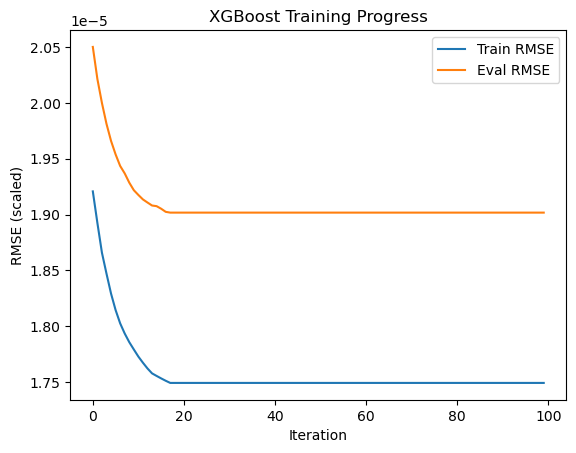

In [21]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np

# 去除缺失值
clean_df = full_df.dropna(subset=["no2_mean", "no2_yesterday", "no2_neighbor_yesterday"])

# 选特征
features = ["no2_yesterday", "no2_neighbor_yesterday"] + [
    col for col in full_df.columns
    if col not in ["no2_mean", "geometry", "date", "geom_id", "no2_yesterday", "no2_neighbor_yesterday"]
]

X = clean_df[features].values
y = clean_df["no2_mean"].values.reshape(-1, 1)  # 目标需要2D给scaler

# 划分训练测试集（不打乱）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 归一化
scaler_X = MinMaxScaler()
# scaler_y = MinMaxScaler()

# 只用训练数据fit，避免数据泄漏
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# y_train_scaled = scaler_y.fit_transform(y_train).ravel()  # ravel转成1D，xgboost需要
# y_test_scaled = scaler_y.transform(y_test).ravel()

# 创建 DMatrix，带特征名
dtrain = xgb.DMatrix(X_train_scaled, label=y_train, feature_names=features)
dtest = xgb.DMatrix(X_test_scaled, label=y_test, feature_names=features)

params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "max_depth": 6,
    "eta": 0.1
}

evals = [(dtrain, "train"), (dtest, "eval")]
num_round = 100

evals_result = {}

bst = xgb.train(
    params, dtrain, num_round, evals,
    evals_result=evals_result,
    verbose_eval=True
)

# 预测，得到的是归一化后的预测值
y_pred = bst.predict(dtest)

# 反归一化回原始尺度
# y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

print("Final RMSE (original scale):", mean_squared_error(y_test.ravel(), y_pred, squared=False))

# 画训练过程RMSE曲线（归一化指标）
plt.plot(evals_result['train']['rmse'], label='Train RMSE')
plt.plot(evals_result['eval']['rmse'], label='Eval RMSE')
plt.xlabel('Iteration')
plt.ylabel('RMSE (scaled)')
plt.title('XGBoost Training Progress')
plt.legend()
plt.show()

Feature Importances:
no2_neighbor_yesterday: 3.5224784369347617e-06
no2_yesterday: 1.718933276606549e-06
pop_sum_m: 1.5486119764318573e-06
NTL_mean: 1.4023540870766737e-06
road_len: 0
road_share: 0
poi_count: 0
poi_share: 0
lu_industrial_area: 0
lu_industrial_share: 0
lu_commercial_area: 0
lu_commercial_share: 0
lu_residential_area: 0
lu_residential_share: 0
lu_retail_area: 0
lu_retail_share: 0
lu_farmland_area: 0
lu_farmland_share: 0
lu_farmyard_area: 0
lu_farmyard_share: 0
road_motorway_len: 0
road_trunk_len: 0
road_primary_len: 0
road_secondary_len: 0
road_tertiary_len: 0
road_residential_len: 0
fossil_pp_count: 0


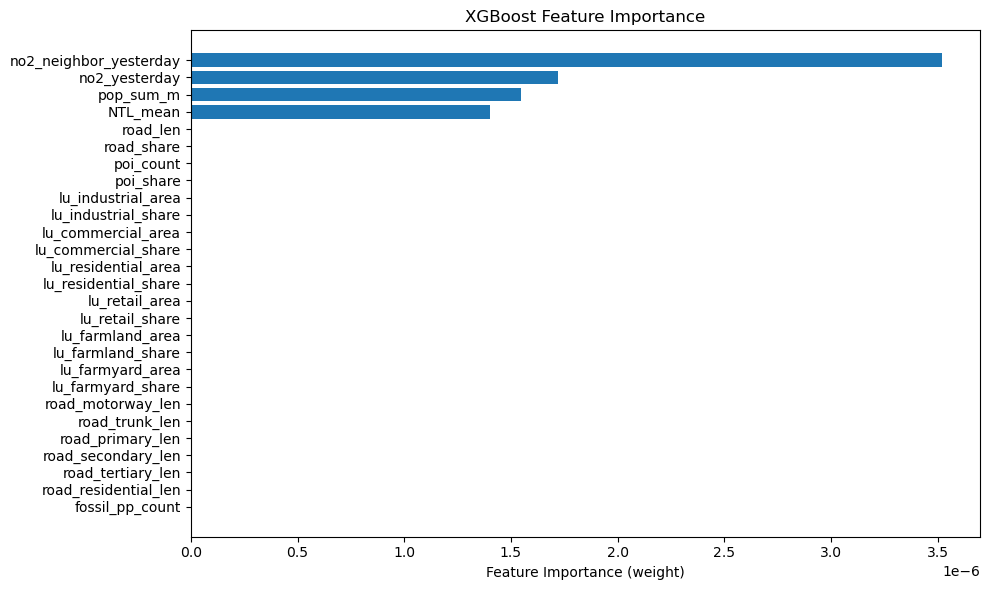

In [22]:

# 输出特征重要性
importance_dict = bst.get_score(importance_type='gain')  # weight
importances = [(feat, importance_dict.get(feat, 0)) for feat in features]
importances.sort(key=lambda x: x[1], reverse=True)

print("Feature Importances:")
for feat, score in importances:
    print(f"{feat}: {score}")

plt.figure(figsize=(10, 6))
plt.barh([i[0] for i in importances][::-1], [i[1] for i in importances][::-1])
plt.xlabel("Feature Importance (weight)")
plt.title("XGBoost Feature Importance")
plt.tight_layout()
plt.show()

### Baghdad

In [44]:
import geopandas as gpd
import pandas as pd
from tqdm import tqdm
from datetime import timedelta, datetime
import os

# 假设文件按日期排序，文件名可解析为日期
mesh_bag = DATA_PATH / 'baghdad-mesh-data'
file_paths = sorted(mesh_bag.glob("*.gpkg"))  # 你的 730 个 GPKG 文件路径

all_data = []

for i, path in tqdm(enumerate(file_paths), total=len(file_paths)):
    date = datetime(2023, 1, 1) + timedelta(days=i)  # 修改起始日期为真实值
    gdf = gpd.read_file(path)
    gdf["date"] = date
    all_data.append(gdf)

full_bag_df = pd.concat(all_data, ignore_index=True)


100%|██████████| 731/731 [01:01<00:00, 11.94it/s]
C:\Users\87383\AppData\Local\Temp\ipykernel_30340\1749724562.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_bag_df = pd.concat(all_data, ignore_index=True)


In [45]:
## Yesterday NO2
full_bag_df.sort_values(["geom_id", "date"], inplace=True)
full_bag_df["no2_yesterday"] = full_bag_df.groupby("geom_id")["no2_mean"].shift(1)


In [46]:
import warnings
from libpysal.weights import KNN

# 假设 sample_gdf 是某一天的网格
sample_gdf = full_bag_df[full_bag_df['date'] == full_bag_df['date'].min()].reset_index(drop=True)

# 设置 K（邻居个数）
k_neighbors = 8  # 通常选择8邻域

# 构建 KNN 空间权重
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    w = KNN.from_dataframe(sample_gdf, k=k_neighbors)

# row-standardized weights（可选）
w.transform = 'r'

# 构建 geom_id -> 邻居 geom_id 的映射字典
geom_id_to_neighbors_bag = {}

# sample_gdf 的索引 i <=> geom_id 的映射
index_to_geom_id = dict(sample_gdf['geom_id'].items())

for i, neighbors in w.neighbors.items():
    geom_id = index_to_geom_id[i]
    neighbor_ids = [index_to_geom_id[j] for j in neighbors]
    geom_id_to_neighbors_bag[geom_id] = neighbor_ids


In [47]:
geom_id_to_neighbors_bag

{0: [1, 6, 5, 7, 2, 13, 8, 4],
 1: [0, 2, 7, 6, 8, 14, 3, 5],
 2: [1, 8, 3, 7, 9, 0, 15, 6],
 3: [9, 2, 8, 16, 1, 7, 15, 14],
 4: [5, 11, 12, 10, 6, 26, 13, 0],
 5: [6, 4, 12, 0, 13, 11, 7, 27],
 6: [7, 5, 13, 0, 14, 1, 12, 8],
 7: [6, 8, 14, 1, 13, 0, 15, 2],
 8: [7, 15, 2, 9, 14, 1, 16, 3],
 9: [16, 3, 8, 2, 15, 31, 7, 14],
 10: [25, 11, 4, 24, 26, 40, 12, 39],
 11: [26, 12, 4, 10, 27, 5, 25, 13],
 12: [13, 27, 11, 5, 28, 6, 4, 26],
 13: [12, 14, 6, 28, 7, 29, 5, 27],
 14: [13, 15, 7, 29, 28, 30, 8, 6],
 15: [14, 8, 30, 16, 7, 29, 31, 9],
 16: [9, 31, 15, 30, 8, 46, 3, 14],
 17: [18, 32, 33, 19, 47, 48, 34, 49],
 18: [17, 19, 33, 32, 34, 48, 20, 47],
 19: [18, 34, 20, 33, 35, 17, 49, 21],
 20: [21, 35, 19, 36, 34, 22, 50, 18],
 21: [22, 36, 20, 37, 35, 23, 51, 19],
 22: [21, 37, 23, 36, 38, 20, 24, 52],
 23: [24, 38, 22, 39, 37, 21, 25, 53],
 24: [39, 23, 25, 38, 40, 10, 22, 54],
 25: [40, 10, 24, 26, 39, 41, 11, 23],
 26: [41, 27, 11, 25, 42, 40, 12, 10],
 27: [42, 28, 12, 26, 43, 4

In [48]:
# full_df

In [49]:
def compute_neighbor_no2(row, df_dict):
    date = row["date"]
    geom_id = row["geom_id"]
    prev_date = date - timedelta(days=1)
    if prev_date not in df_dict:
        return None
    prev_day_df = df_dict[prev_date]
    neighbors = geom_id_to_neighbors.get(geom_id, [])
    values = prev_day_df[prev_day_df["geom_id"].isin(neighbors)]["no2_mean"]
    return values.mean() if not values.empty else None

# 按天切分数据用于快速访问
df_by_date = {d: gdf for d, gdf in full_bag_df.groupby("date")}
full_bag_df["no2_neighbor_yesterday"] = full_bag_df.apply(lambda row: compute_neighbor_no2(row, df_by_date), axis=1)


In [51]:
full_bag_df.to_parquet(DATA_PATH / "temp" / "full_bag_df.parquet", engine="pyarrow", compression="snappy")

import pandas as pd
full_bag_df = pd.read_parquet(DATA_PATH / "temp" / "full_bag_df.parquet", engine="pyarrow")


[0]	train-rmse:0.07575	eval-rmse:0.08599
[1]	train-rmse:0.07535	eval-rmse:0.08557


d:\Software\Anaconda3\envs\gdp_env\Lib\site-packages\xgboost\core.py:723: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[2]	train-rmse:0.07501	eval-rmse:0.08523
[3]	train-rmse:0.07472	eval-rmse:0.08495
[4]	train-rmse:0.07449	eval-rmse:0.08470
[5]	train-rmse:0.07429	eval-rmse:0.08445
[6]	train-rmse:0.07412	eval-rmse:0.08427
[7]	train-rmse:0.07397	eval-rmse:0.08409
[8]	train-rmse:0.07384	eval-rmse:0.08393
[9]	train-rmse:0.07372	eval-rmse:0.08380
[10]	train-rmse:0.07363	eval-rmse:0.08371
[11]	train-rmse:0.07353	eval-rmse:0.08361
[12]	train-rmse:0.07346	eval-rmse:0.08354
[13]	train-rmse:0.07339	eval-rmse:0.08348
[14]	train-rmse:0.07333	eval-rmse:0.08341
[15]	train-rmse:0.07326	eval-rmse:0.08337
[16]	train-rmse:0.07321	eval-rmse:0.08332
[17]	train-rmse:0.07315	eval-rmse:0.08329
[18]	train-rmse:0.07310	eval-rmse:0.08326
[19]	train-rmse:0.07305	eval-rmse:0.08323
[20]	train-rmse:0.07299	eval-rmse:0.08318
[21]	train-rmse:0.07293	eval-rmse:0.08316
[22]	train-rmse:0.07289	eval-rmse:0.08314
[23]	train-rmse:0.07285	eval-rmse:0.08312
[24]	train-rmse:0.07281	eval-rmse:0.08311
[25]	train-rmse:0.07277	eval-rmse:0.08309


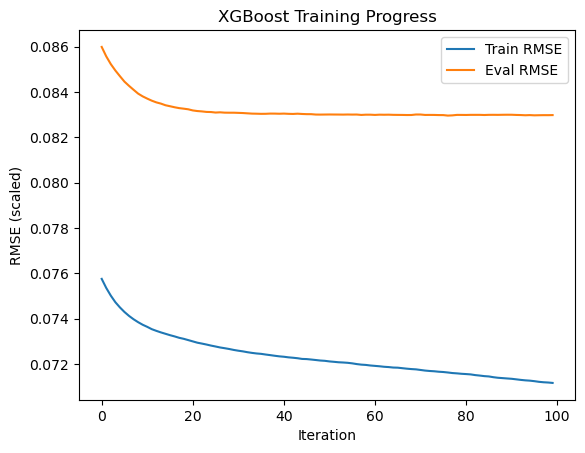

Feature Importances:
no2_yesterday: 1899.0
NTL_mean: 1547.0
no2_neighbor_yesterday: 1228.0
pop_sum_m: 451.0
lu_farmland_area: 359.0
road_len: 248.0
road_residential_len: 133.0
road_secondary_len: 72.0
road_tertiary_len: 53.0
road_motorway_len: 46.0
lu_industrial_area: 37.0
lu_residential_area: 21.0
road_trunk_len: 16.0
lu_commercial_area: 8.0
road_share: 0
poi_count: 0
poi_share: 0
lu_industrial_share: 0
lu_commercial_share: 0
lu_residential_share: 0
lu_retail_area: 0
lu_retail_share: 0
lu_farmland_share: 0
lu_farmyard_area: 0
lu_farmyard_share: 0
road_primary_len: 0
fossil_pp_count: 0


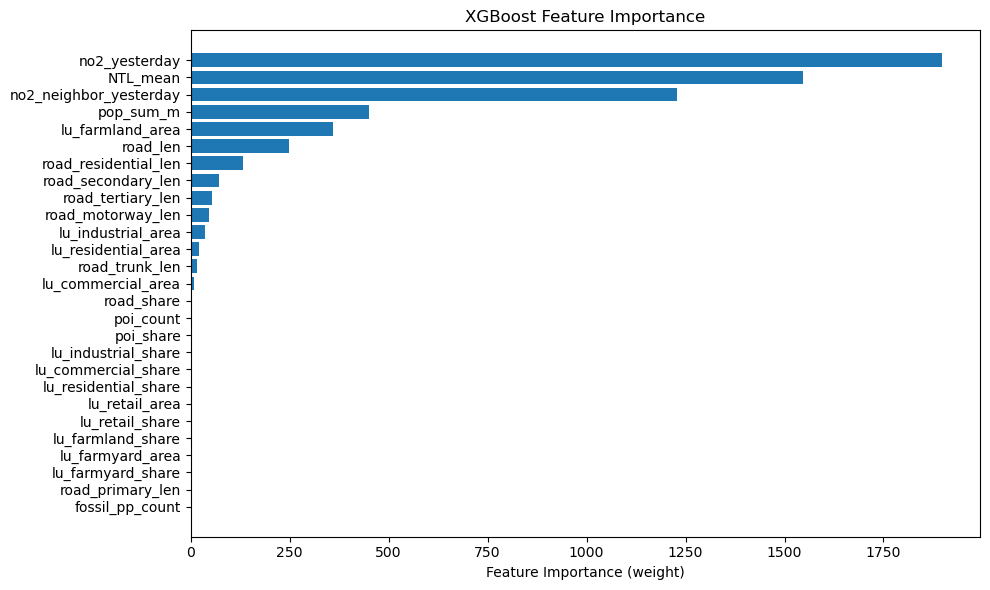

In [52]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np

# 去除缺失值
clean_df = full_bag_df.dropna(subset=["no2_mean", "no2_yesterday", "no2_neighbor_yesterday"])

# 选特征
features = ["no2_yesterday", "no2_neighbor_yesterday"] + [
    col for col in full_bag_df.columns
    if col not in ["no2_mean", "geometry", "date", "geom_id", "no2_yesterday", "no2_neighbor_yesterday"]
]

X = clean_df[features].values
y = clean_df["no2_mean"].values.reshape(-1, 1)  # 目标需要2D给scaler

# 划分训练测试集（不打乱）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 归一化
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# 只用训练数据fit，避免数据泄漏
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train).ravel()  # ravel转成1D，xgboost需要
y_test_scaled = scaler_y.transform(y_test).ravel()

# 创建 DMatrix，带特征名
dtrain = xgb.DMatrix(X_train_scaled, label=y_train_scaled, feature_names=features)
dtest = xgb.DMatrix(X_test_scaled, label=y_test_scaled, feature_names=features)

params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "max_depth": 6,
    "eta": 0.1
}

evals = [(dtrain, "train"), (dtest, "eval")]
num_round = 100

evals_result = {}

bst = xgb.train(
    params, dtrain, num_round, evals,
    evals_result=evals_result,
    verbose_eval=True
)

# 预测，得到的是归一化后的预测值
y_pred_scaled = bst.predict(dtest)

# 反归一化回原始尺度
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

print("Final RMSE (original scale):", mean_squared_error(y_test.ravel(), y_pred, squared=False))

# 画训练过程RMSE曲线（归一化指标）
plt.plot(evals_result['train']['rmse'], label='Train RMSE')
plt.plot(evals_result['eval']['rmse'], label='Eval RMSE')
plt.xlabel('Iteration')
plt.ylabel('RMSE (scaled)')
plt.title('XGBoost Training Progress')
plt.legend()
plt.show()

# 输出特征重要性
importance_dict = bst.get_score(importance_type='weight')
importances = [(feat, importance_dict.get(feat, 0)) for feat in features]
importances.sort(key=lambda x: x[1], reverse=True)

print("Feature Importances:")
for feat, score in importances:
    print(f"{feat}: {score}")

plt.figure(figsize=(10, 6))
plt.barh([i[0] for i in importances][::-1], [i[1] for i in importances][::-1])
plt.xlabel("Feature Importance (weight)")
plt.title("XGBoost Feature Importance")
plt.tight_layout()
plt.show()
